In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

In [ ]:
# Import the data generated via matlab/simulink:

# see get_data.py for more info

#save_data_test_revised.csv

data_tensor, PSW_max = get_data(path = r"data\testrun_festodaten.csv", timesteps_from_data=0,
                                 skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = True, normalise_s_w=False, rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=2)

In [31]:
from torch.utils.data import Dataset, DataLoader

class custom_simple_dataset(Dataset):

    def __init__(self, data, window_size):

        self.data = data
        self.ws = window_size

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):

        inp = self.data[idx, :, :]
        label = self.data[idx, self.ws:, 1:]

        return inp, label


# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

cpu


In [ ]:

def fr(v):

#parBoost_gen.d_b  = 3.2;                    % Dämpfungskonste Booster in [Ns/m]  Update AP: 2021Feb alter Wert 33.184
#parBoost_gen.F_c  = 0.5;                      % Coulombreibkraft Booster in [N] Update AP: 2021Feb alter Wert: 1.53;

    d = 3.2
    F_c  = 0.5

    fr = - d * v - F_c * torch.sign(v)


    return fr

def fk(s,v):

# % Paramter Kontaktmodell
# % Unterer Anschlag
# parBoost_gen.c_bwl = 166e3;          % Federkonstante unterer Anschlag in [N/m]
# parBoost_gen.d_bwl = 474;            % Dämpfungskonstante unterer Anschlag in [Ns/m]
# parBoost_gen.s_0bwl = 0.3e-4;        % Kontaktpunkt unterer Anschlag in [m] 
# % Oberer Anschlag
# parBoost_gen.c_bwu = 166e3;                         % Federkonstante oberer Anschlag in [N/m]
# parBoost_gen.d_bwu = 474;                           % Dämpfungskonstante oberer Anschlag in [Ns/m]
# parBoost_gen.s_0bwu = parBoost_gen.s_b_max - 0.12e-4;     % Kontaktpunkt oberer Anschlag in [m]
#parBoost_gen.s_b_max = 0.6e-3;                                      % Maximaler Hub in [m]

    s_u =  0.6e-3 - 0.12e-4
    c_u = 166e3
    d_u = 474

    c_l = 166e3
    s_l =  0.3e-4
    d_l = 474


    if s_u <= s:
        
        fk = -c_u * (s - s_u) - d_u * v * (s - s_u)

    elif s <= s_l:

        fk = c_l * (s - s_l) - d_l * v * (s - s_l)

    else:
        fk = 0

    return fk

def ODE_right_side(x, pressure, physics_rescaling=None):

    #rescale to physical units

   # x[:, :,0] = x[:, :,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
   # x[:, :,1] = x[:, :,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
   # pressure[:, :,0] = pressure[:, :,0]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    x_dt = torch.zeros_like(x[:,:,0:1]) # write s' = v (v from real data)  
    #          v'  = 1/m ( A * ( p - p0) - c * (s - s0) + fr(v) + fk(s,v) )  

    # andere Formulierung: fs = -(c_b*s_b - F_cb0) statt -c_b *(s_b - s_0b);

    #          v'  = 1/m ( A * ( p - p0) - (c_b*s_b - F_cb0) + fr(v) + fk(s,v) )  


    m = 1.8931e-3                         # 1.8931e-3;              % Masse Booster in [kg]
    A = 0.5*(71.0526e-6 + 78.9793e-6 )  # 0.5*(parBoost_gen.A_b_closed + parBoost_gen.A_b_open);   % Mittlere Fläche Booster in [m²]                                
                                            # % Anfangswerte der Boostereinheit
    p0 = 1e5                                # parBoost_gen.s_b_0 = 3e-4;
    s0 = 3e-4                               # parBoost_gen.p_b_0 = 1e5;
    c = 16.5e3                              # parBoost_gen.c_b  = 16.5e3;                 % Federkonstante Booster in [N/m]
    F_cb0 = -4.3                            #parBoost_gen.F_cb0 = -4.3;                    % Federvorspannkraft (Kraft der Feder bei sb=0) [N]


    for i in range(x_dt.size(dim=0)):
        for time in range(x_dt.size(dim=1)):

            p = pressure[i, time, 0] * (physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
            s =  x[i, time, 0] * (physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
            v = x[i, time, 1] * (physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]

            x_dt[i, time, 0:1] =  1/m * ( A * ( p - p0) - (c * s - F_cb0) + fr(v) + fk(s,v) ) 

    return x_dt

def train(input_data, model, weight_decay, learning_rate=0.001, ws=0, PSW_max=0, physics_loss_weight = 0.0001):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []
    total_physics_loss = []

    # s' = v
    # v' = f(s,v,p)
    # 
    # (s,v) = model return (we can also return the derivatives calculated by the model!)
    #
    # (s,v), (s', v') = model (return are vectors len = timesteps modulo init values)
    #  
    #  physic_error = 1/len * sum( mse ( (s', v') - (v, f(s,v,p))  ))
    #
    #  def f(s,v, p) from matlab (bad with normalisation!!!)
    #

    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        
        output, _, derivative_sv = model(x)

        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(output, y)

        # calc physics loss
        physics_loss=0
        if physics_loss_weight != 0:
        
         pressure = x[:, ws:, 0:1] # Anfangswerte sind abgeschnitten weil len(output) == len(x) - windowsize 
         assert pressure.size(dim=1) == output.size(dim=1)
         physics_loss = physics_loss_weight * loss_fn(ODE_right_side(output, pressure, PSW_max), ODE_right_side(y, pressure, PSW_max))
         
        losses = loss + physics_loss

        losses.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
        total_physics_loss.append(physics_loss.detach().cpu().numpy())
   # return the average error of the next step prediction

   
    return np.mean(total_loss), np.mean(total_physics_loss)

In [ ]:

params =           {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 1,
                           "epochs" : 100,
                           "learning_rate" : 0.001,
                           "part_of_data" : 50, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.3,
                           "future_decay"  : 0.5,
                           "batch_size" : 2,
                           "future" : 10,
                           "cut_off_timesteps" : 300,
                           "drop_half_timesteps": True,
                           "physics_loss_weight" : 0.001
                        }

# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], rungekutta=False).to(device)
# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

# input_data2, PSW_max = get_data(path = "save_data_test5.csv", 
#                         timesteps_from_data=0, 
#                         skip_steps_start = 0,
#                         skip_steps_end = 0, 
#                         drop_half_timesteps = params["drop_half_timesteps"],
#                         normalise_s_w="minmax",
#                         rescale_p=False,
#                         num_inits=params["part_of_data"])

# input_data3, PSW_max = get_data(path = "Testruns_from_trajectory_generator_t2_t6_revised.csv", 
#                         timesteps_from_data=0, 
#                         skip_steps_start = 0,
#                         skip_steps_end = 0, 
#                         drop_half_timesteps = params["drop_half_timesteps"],
#                         normalise_s_w="minmax",
#                         rescale_p=False,
#                         num_inits=params["part_of_data"])

input_data = input_data1#torch.cat((input_data1, input_data2, input_data3))
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = custom_simple_dataset(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch, loss_physics = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"],
                        ws=params["window_size"], PSW_max = PSW_max, physics_loss_weight=params["physics_loss_weight"])
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%2 == 0:    

        print("Train loss:", loss_epoch)
        print("physics loss:", loss_physics)

        _,_, err_train = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False,
                               num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_test = test(input_data, model, model_type = "or_lstm", window_size=params["window_size"], display_plots=False, num_of_inits = 100, set_rand_seed=True, physics_rescaling = PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

input_data size torch.Size([1200, 550, 3])


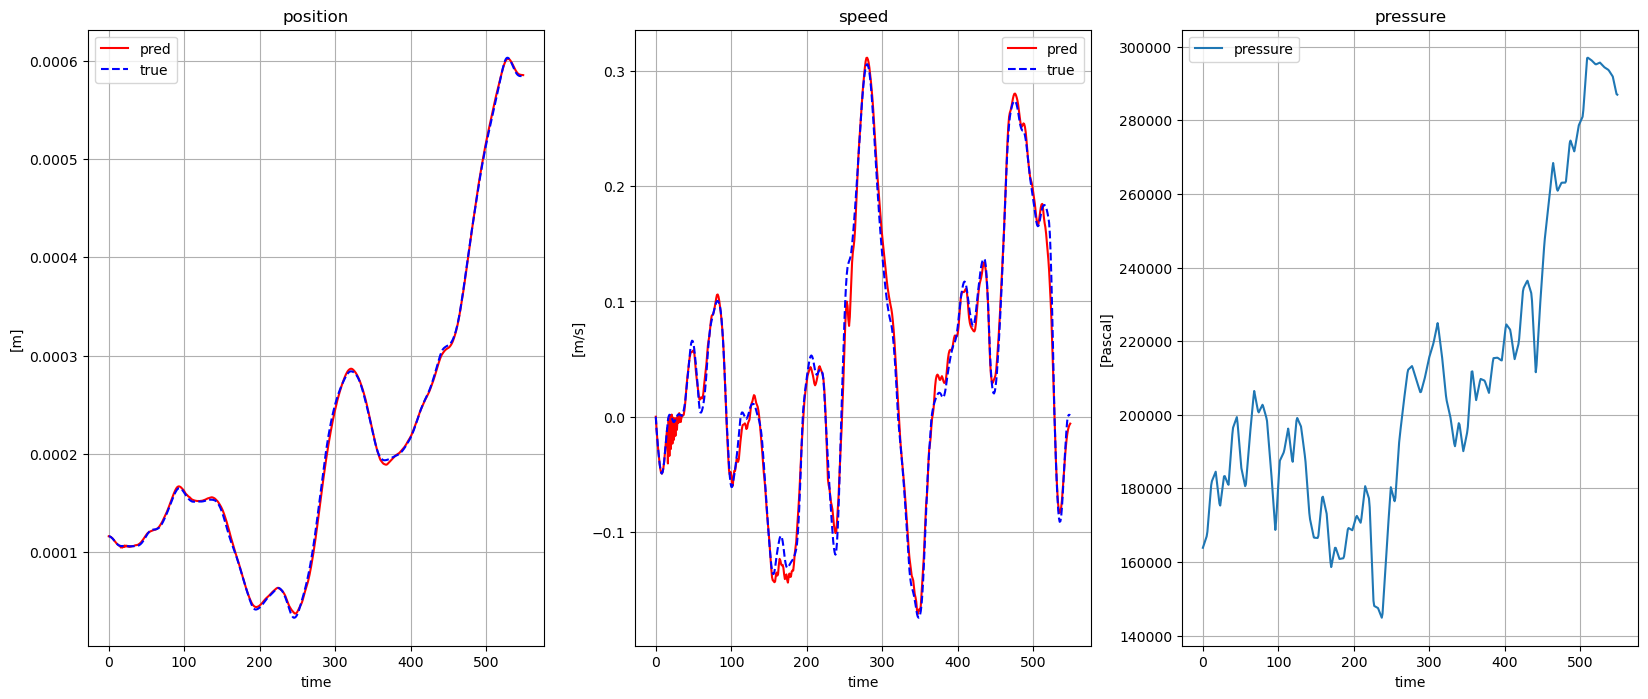

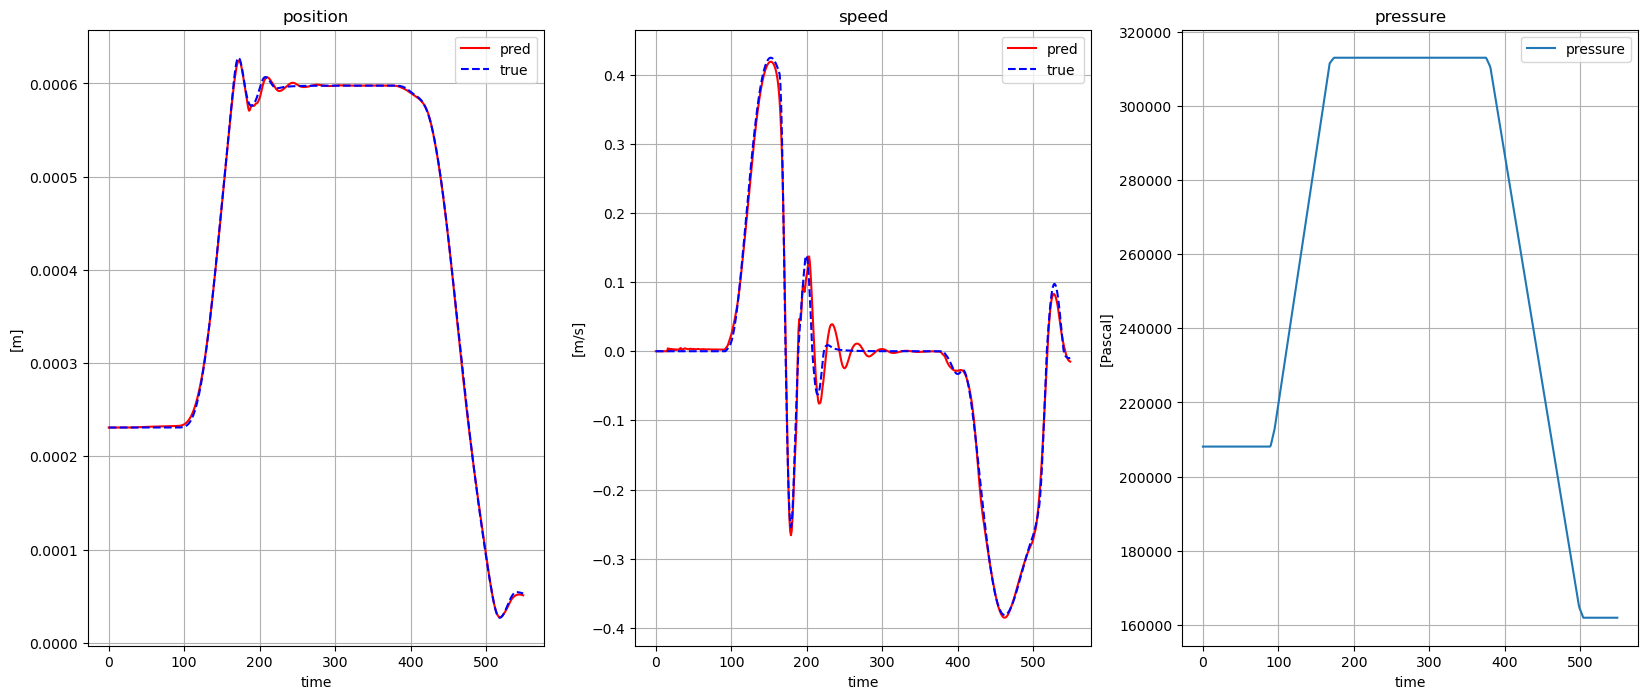

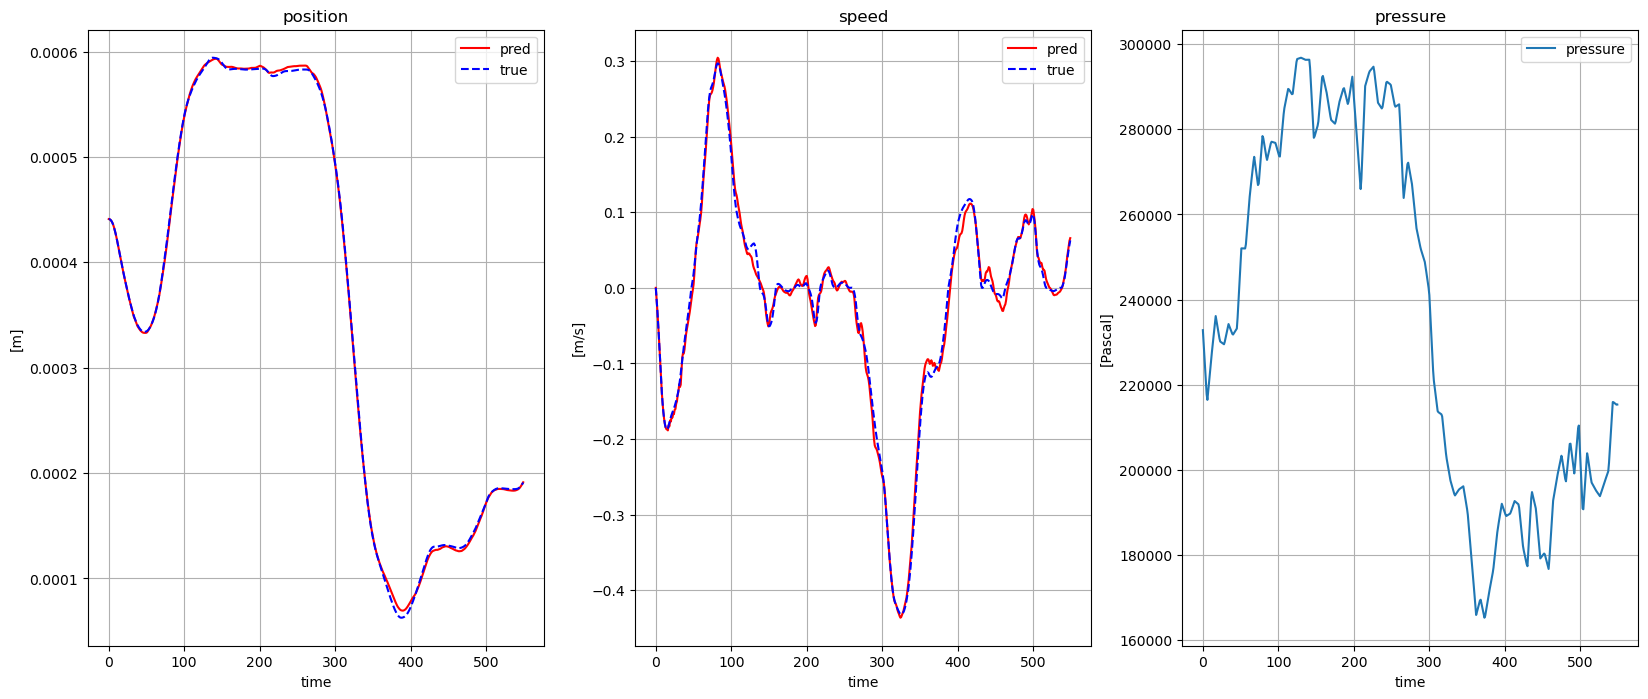

In [41]:
# Save the model
# path = f"Ventil_trained_NNs\lstm_ws0.pth"
# #
# torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "working_networks\OR_lstm_16_8_3_best_V2.pth"

params =                 {
                           "experiment_number" : 2,
                           "window_size" : 16,
                           "h_size" : 8,
                           "l_num" : 3,
                           "epochs" : 3000,
                           "learning_rate" : 0.0008,
                           "part_of_data" : 0, 
                           "weight_decay" : 0,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 20,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                        }



input_data1, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data3, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_t2_t6_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])
                        

input_data = torch.cat((input_data1, input_data2, input_data3))

np.random.seed(1234)
print("input_data size", input_data.size())
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
np.random.shuffle(train_inits)
np.random.shuffle(test_inits)
test_data = input_data[test_inits,:,:]
np.random.seed()

# Initialize the LSTM model

model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"], stepsize=1, rungekutta=False)

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]
#%matplotlib qt 
#%matplotlib inline 

#test_loss, test_loss_deriv, total_loss, physloss
test_loss, test_loss_deriv, total_loss = test(test_data, model, model_type = "or_lstm", window_size=params["window_size"],
                                                         display_plots=True, num_of_inits = 3, set_rand_seed=False, physics_rescaling = PSW_max, additional_data=None)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)

#[350000.0, 0.0006, 1.7, 0.0, 0.0, -1.7]

In [ ]:


def fr(v):

    d = 3.2
    F_c  = 0.5
    #fr = - d * v - F_c * np.sign(v)
    fr = - d * v - F_c * np.tanh(v/0.1)

    return fr

def fk(s,v):

    s_u =  0.6e-3 - 0.12e-4
    c_u = 166e3
    d_u = 474
    c_l = 166e3
    s_l =  0.3e-4
    d_l = 474

    fk = 0

    if s_u <= s:
        
        fk = -c_u * (s - s_u) - d_u * v * (s - s_u)

    elif s <= s_l:

        fk = c_l * (s - s_l) - d_l * v * (s - s_l)

    return fk


def plot_results(x, pred, pred_next_step=None, physics_rescaling=None):


    if x.dim() == 3:
        x = x.view(x.size(dim=1), x.size(dim=2))
    if pred.dim() == 3:
        pred = pred.view(pred.size(dim=1), pred.size(dim=2))
    if pred_next_step != None:
        if pred_next_step.dim() == 3:
            pred_next_step = pred_next_step.view(pred_next_step.size(dim=1), pred_next_step.size(dim=2))

        #scale back:    
    if physics_rescaling != None:

        # we invert:
        # x = (x - xmin)/(xmax - xmin)
        # x * (xmax - xmin) + xmin

        pred[:,0] = pred[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
       # pred[:,0] = pred[:,0]/1e5
        pred[:,1] = pred[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        pred[:,2] = pred[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
        x[:,0] = x[:,0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
       # x[:,0] = x[:,0]/1e5
        x[:,1] = x[:,1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
        x[:,2] = x[:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

    figure , axs = plt.subplots(1,3,figsize=(20,9))


    axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
    axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
    axs[0].set_title("position")
    axs[0].set_ylabel("[m]")
    axs[0].set_xlabel("time")
    axs[0].grid()
    axs[0].legend()


    axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
    axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
    axs[1].set_title("speed")
    axs[1].set_ylabel("[m/s]")
    axs[1].set_xlabel("time")
    axs[1].grid()
    axs[1].legend()

    axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
    axs[2].set_title("pressure")
    axs[2].set_ylabel("[Pascal]")
    axs[2].set_xlabel("time")
    axs[2].grid()
    axs[2].legend()


    if pred_next_step != None:
        axs[0].plot(pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
        axs[1].plot(pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")


    plt.grid(True)
    plt.legend()
    plt.show()

def test(data, model, model_type = "or_lstm", window_size=10, display_plots=False, num_of_inits = 5, set_rand_seed=True, physics_rescaling = 0):

    if model_type not in ["or_lstm", "lstm", "mlp", "gru", "tcm"]:
        print("Error: model_type = ", model_type, "available options are: [or_lstm, lstm, mlp, gru, tcm]")
        return 0

    
    device = "cpu" if data.get_device() == -1 else "cuda:0"
    
    if data.dim() != 3:
        print("data tensor has unexpected dimension", data.dim(), "expected", 3 )
        return 0
    
    timesteps = data.size(dim=1)

    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0
   
    if set_rand_seed:
     np.random.seed(1234)


    
    if model_type in ["or_lstm", "gru"]:
        for i, x in enumerate(data):
            if i > 0: 
                break
            x = data[num_of_inits]
            x=x.to(device)        
            x = x.view(1,x.size(dim=0), x.size(dim=1))
    
            with torch.inference_mode():
    
                pred = torch.zeros((timesteps, 3), device=device)
    
                if window_size > 1:
                    pred[0:window_size, :] = x[0, 0:window_size, :]
                    pred[:, 0] = x[0, :, 0]
    
                else:
                    pred[0, :] = x[0, 0, :]
                    pred[:, 0] = x[0, :, 0]
      
                        # (s' ,  v')        
                out, _, derivative_sv = model(x)
                pred[window_size:,1:] = out
                print(out.size())

#######################################################
                physics_loss=0

                x_dt = torch.zeros_like(x[:,window_size:,2:])
                x_dt_net = torch.zeros_like(x[:,window_size:,2:])

                m = 1.8931e-3                         # 1.8931e-3;              % Masse Booster in [kg]
                A = 0.5*(71.0526e-6 + 78.9793e-6 )  # 0.5*(parBoost_gen.A_b_closed + parBoost_gen.A_b_open);   % Mittlere Fläche Booster in [m²]                                
                                                        # % Anfangswerte der Boostereinheit
                p0 = 1e5                                # parBoost_gen.s_b_0 = 3e-4;
                s0 = 3e-4                               # parBoost_gen.p_b_0 = 1e5;
                c = 16.5e3                              # parBoost_gen.c_b  = 16.5e3;                 % Federkonstante Booster in [N/m]
                F_cb0 = -4.3                            #parBoost_gen.F_cb0 = -4.3;                    % Federvorspannkraft (Kraft der Feder bei sb=0) [N]

                for i in range(x_dt.size(dim=0)):
                    for time in range(window_size, x_dt.size(dim=1)):

                        p =  x[i, time, 0]*(physics_rescaling[0] - physics_rescaling[3]) + physics_rescaling[3]
                        s =  x[i, time, 1]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
                        v =  x[i, time, 2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

                        x_dt[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s - F_cb0) + fr(v))
                        #x_dt[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s - F_cb0) + fr(v) + fk(s,v) )
                        #x_dt[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s - F_cb0))

                        s_net =  out[i, time - window_size, 0]*(physics_rescaling[1] - physics_rescaling[4]) + physics_rescaling[4]
                        v_net =  out[i, time - window_size, 1]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]

                        x_dt_net[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s_net - F_cb0) + fr(v_net)) 
                        #x_dt_net[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s_net - F_cb0) + fr(v_net) + fk(s_net, v_net) )
                        #x_dt_net[i, time - window_size, 0:] =  1/m * ( A * ( p - p0) - (c * s_net - F_cb0)) 

                        if abs(x_dt_net[i, time - window_size, 0:] -  x_dt[i, time - window_size, 0:]) > 100:
                            print("netz werte:", "s", s_net.numpy(), "v", v_net.numpy())
                            print("werte true:", "s", s.numpy(), "v", v.numpy())
                            print("f(netz)", x_dt_net[i, time - window_size, 0:], "f(true)" ,x_dt[i, time - window_size, 0:])
                            print("fr net", fr(v_net), "fk net", fk(s_net, v_net))
                            print("fr true", fr(v), "fk true", fk(s, v))
                            print("sign net", np.sign(v_net), "true sign" , np.sign(v))
                            print("---------------------------------------------------------------")



                # numeric differentiation

                v_rescaled = x[0,:,2]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
                v_net_rescaled = out[0,:,1]*(physics_rescaling[2] - physics_rescaling[5]) + physics_rescaling[5]
                h = 1e-5

                a_numeric = np.gradient(v_rescaled.numpy()) / h
                a_numeric2 = (v_rescaled[1:] - v_rescaled[:-1]) / h
                a_net_numeric = np.gradient(v_net_rescaled.numpy()) / h

                # physics loss
                loss_fn = nn.MSELoss()
               # physics_loss = loss_fn(x_dt[0, :, 0], x_dt_net[0, :, 0]) 
                physics_loss = loss_fn(x_dt, x_dt_net)

                n = x_dt.size(dim=1)
                physics_loss_manuel = 1/ n * np.sum([ (x_dt[0,i,0] - x_dt_net[0,i,0])**2 for i in range(n) ])
                print(physics_loss_manuel)
                plt.plot((x_dt[0,:,0] - x_dt_net[0,:,0]))
                plt.show()
                figure , axs = plt.subplots(1,1,figsize=(20,9))

                print(x_dt.size(), x_dt_net.size(), len(a_numeric))

                axs.plot(x_dt[i, :, 0:].detach().cpu().numpy(), color="red", label="a true")
                axs.plot(x_dt_net[i, :, 0:].detach().cpu().numpy(), color="blue", label="a net")
                axs.plot(a_numeric[window_size:], color="green", label="a numeric")
                #axs.plot(a_numeric2[window_size:], color="yellow", label="[ v(t+1)-v(t) ] / h")
                axs.plot(a_net_numeric, color="purple", label="a_net_numeric")

                axs.grid(True)
                axs.legend()


                #plt.plot(derivative_sv.numpy())
                plt.show()
                
#######################################################
            
                test_loss += loss_fn(pred[window_size:, 1], x[0, window_size:, 1]).detach().cpu().numpy()
                test_loss_deriv += loss_fn(pred[window_size:, 2], x[0, window_size:, 2]).detach().cpu().numpy()
                total_loss += loss_fn(pred[window_size:, 1:], x[0, window_size:, 1:]).detach().cpu().numpy()

                if display_plots:
                    plot_results(x, pred, pred_next_step=None, physics_rescaling=physics_rescaling)

    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss), physics_loss

In [15]:
class LSTMmodel(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, layers):

        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):

        lstm_out, hidden = self.lstm(seq)           
        out = self.linear(lstm_out)

            
        return out 


In [16]:
model = LSTMmodel(3, 3, 2, 1)

In [12]:
list(model.parameters())


[Parameter containing:
 tensor([[-0.5445,  0.2184, -0.2078],
         [-0.4084,  0.4354,  0.0670],
         [ 0.5745, -0.2223,  0.1249],
         [ 0.2474, -0.1401, -0.0159],
         [ 0.4428, -0.3987, -0.2789],
         [ 0.2581, -0.3912, -0.4630],
         [ 0.0872, -0.4911,  0.1978],
         [ 0.0470, -0.5248,  0.2457],
         [-0.3145, -0.0527, -0.4643],
         [-0.1289,  0.4258, -0.2930],
         [-0.0534, -0.2194, -0.0302],
         [-0.0687, -0.1244, -0.1509]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3521,  0.5275,  0.3049],
         [ 0.2362, -0.0544, -0.4505],
         [-0.0610, -0.4103, -0.3361],
         [ 0.4213,  0.1269,  0.3716],
         [-0.4746,  0.5360, -0.0989],
         [-0.4602, -0.2509,  0.2670],
         [-0.3303, -0.0175, -0.5110],
         [ 0.4510,  0.4686,  0.5440],
         [ 0.2399, -0.2526, -0.3466],
         [-0.3830, -0.4909,  0.1535],
         [-0.1728,  0.2463,  0.2221],
         [ 0.1921,  0.0999,  0.5534]], requires_grad=True)

In [27]:
a = torch.tensor([[1., 2., 3.]], requires_grad=True)
b = torch.tensor([[1.45, 3.55, 0.2]], requires_grad=True)
c = torch.tensor([[0.1, 2.9, 1.1]], requires_grad=True)

model(a)
print("params", list(model.parameters())[0])
model(b)
print("params", list(model.parameters())[0])
o = model(c)
print(o)

o2 = model(torch.cat((a,b,c)))
print(o2)

params Parameter containing:
tensor([[-0.5513, -0.4525, -0.2070],
        [-0.5484, -0.2493, -0.2537],
        [-0.1059, -0.5731,  0.2435],
        [ 0.0300, -0.4748, -0.1941],
        [ 0.2553,  0.3392, -0.2829],
        [-0.4942,  0.3446,  0.1126],
        [ 0.4269,  0.0228, -0.1773],
        [-0.3093,  0.3578,  0.1095],
        [-0.1560, -0.3295, -0.0661],
        [ 0.0554, -0.0189, -0.1296],
        [ 0.4895, -0.1112, -0.4148],
        [-0.2176, -0.5606, -0.0166]], requires_grad=True)
params Parameter containing:
tensor([[-0.5513, -0.4525, -0.2070],
        [-0.5484, -0.2493, -0.2537],
        [-0.1059, -0.5731,  0.2435],
        [ 0.0300, -0.4748, -0.1941],
        [ 0.2553,  0.3392, -0.2829],
        [-0.4942,  0.3446,  0.1126],
        [ 0.4269,  0.0228, -0.1773],
        [-0.3093,  0.3578,  0.1095],
        [-0.1560, -0.3295, -0.0661],
        [ 0.0554, -0.0189, -0.1296],
        [ 0.4895, -0.1112, -0.4148],
        [-0.2176, -0.5606, -0.0166]], requires_grad=True)
tensor([[-0.